In [1]:
import numpy as np
import pandas as pd
import shap
import torch
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

shap.initjs()


/Users/pc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load lstm model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=64, output_dim=4):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

model = LSTMClassifier()
model.load_state_dict(torch.load("../models/lstm_baseline.pth"))
model.eval()

print("LSTM model loaded successfully.")



LSTM model loaded successfully.


In [3]:
# load metadate and predictions
metadata = pd.read_csv("../data/metadata.csv")
preds = pd.read_csv("../results/lstm_predictions.csv")

df = preds.merge(metadata[["filepath", "gender"]], on="filepath", how="left")
df.head()



,filepath,emotion,gender_x,emotion_label,predicted,gender_y
0,../data/RADVESS/Actor_02/03-01-05-01-02-01-02.wav,angry,female,0,sad,female
1,../data/RADVESS/Actor_20/03-01-05-01-01-01-20.wav,angry,female,0,sad,female
2,../data/RADVESS/Actor_09/03-01-04-01-02-02-09.wav,sad,male,3,sad,male
3,../data/RADVESS/Actor_15/03-01-03-02-01-01-15.wav,happy,male,1,sad,male
4,../data/RADVESS/Actor_05/03-01-05-02-02-01-05.wav,angry,male,0,sad,male


In [21]:
# remove extr gender column
df.drop(columns=["gender_y"], inplace=True)
df.head()

,filepath,emotion,gender_x,emotion_label,predicted
0,../data/RADVESS/Actor_02/03-01-05-01-02-01-02.wav,angry,female,0,sad
1,../data/RADVESS/Actor_20/03-01-05-01-01-01-20.wav,angry,female,0,sad
2,../data/RADVESS/Actor_09/03-01-04-01-02-02-09.wav,sad,male,3,sad
3,../data/RADVESS/Actor_15/03-01-03-02-01-01-15.wav,happy,male,1,sad
4,../data/RADVESS/Actor_05/03-01-05-02-02-01-05.wav,angry,male,0,sad


In [22]:
# rename column from gender_x to gender
df.rename(columns={"gender_x": "gender"}, inplace=True)
df.head()

,filepath,emotion,gender,emotion_label,predicted
0,../data/RADVESS/Actor_02/03-01-05-01-02-01-02.wav,angry,female,0,sad
1,../data/RADVESS/Actor_20/03-01-05-01-01-01-20.wav,angry,female,0,sad
2,../data/RADVESS/Actor_09/03-01-04-01-02-02-09.wav,sad,male,3,sad
3,../data/RADVESS/Actor_15/03-01-03-02-01-01-15.wav,happy,male,1,sad
4,../data/RADVESS/Actor_05/03-01-05-02-02-01-05.wav,angry,male,0,sad


In [4]:
# mfcc extractiion matching and training
def extract_mfcc(path):
    audio, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    max_len = 200
    if mfcc.shape[1] < max_len:
        pad = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad)))
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.T  # shape: (200, 40)



In [5]:
# shap background data
sample_paths = df["filepath"].sample(30, random_state=42).tolist()

background_raw = np.array([extract_mfcc(p) for p in sample_paths])
background = background_raw.reshape(background_raw.shape[0], -1)

background.shape



(30, 8000)

In [9]:
# shap wrapper for lstm
def model_predict(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32)
        out = model(x_tensor)
        return out.numpy()


In [6]:
# model predict wrapper
def model_predict(x):
    x = np.array(x)                      # shape: (batch, 8000)
    x = x.reshape(x.shape[0], 200, 40)   # back to LSTM shape

    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        out = model(x_tensor)
    return out.numpy()


In [7]:
# shap explainer
explainer = shap.KernelExplainer(model_predict, background)

In [8]:
# choose shap smaples
sample_df = df.sample(50, random_state=42)

X_sample_raw = np.array([extract_mfcc(p) for p in sample_df["filepath"]])
X_sample = X_sample_raw.reshape(X_sample_raw.shape[0], -1)

X_sample.shape



(50, 8000)

In [9]:
# compute shap values
shap_values = explainer.shap_values(X_sample, nsamples=100)


100%|██████████| 50/50 [02:07<00:00,  2.55s/it]


<Figure size 1000x600 with 0 Axes>

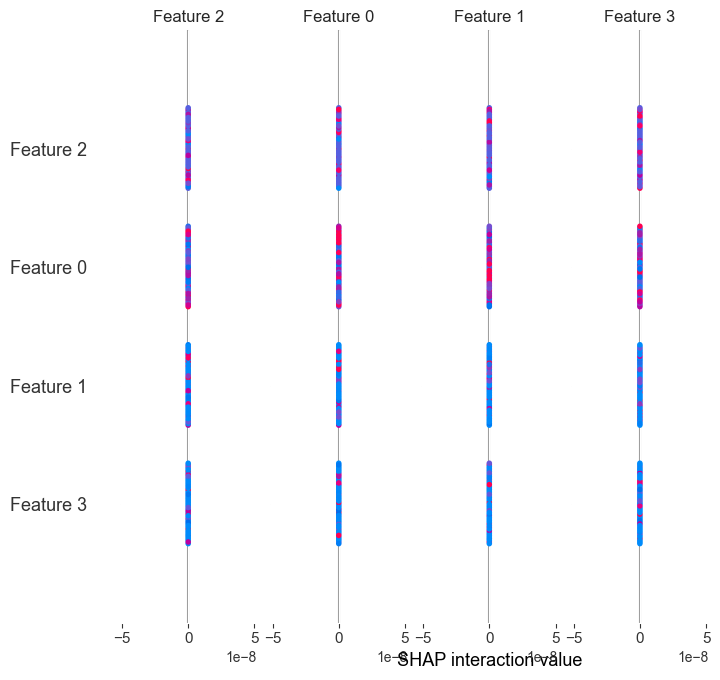

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# BRIGHT theme
plt.style.use("seaborn-v0_8-bright")

plt.figure(figsize=(10,6))

# White background
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# High‑contrast text & ticks
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'   # <-- fixed

# SHAP summary plot with bright colors
shap.summary_plot(shap_values, X_sample, show=False, color=plt.cm.tab10)

plt.savefig("../results/shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 1000x600 with 0 Axes>

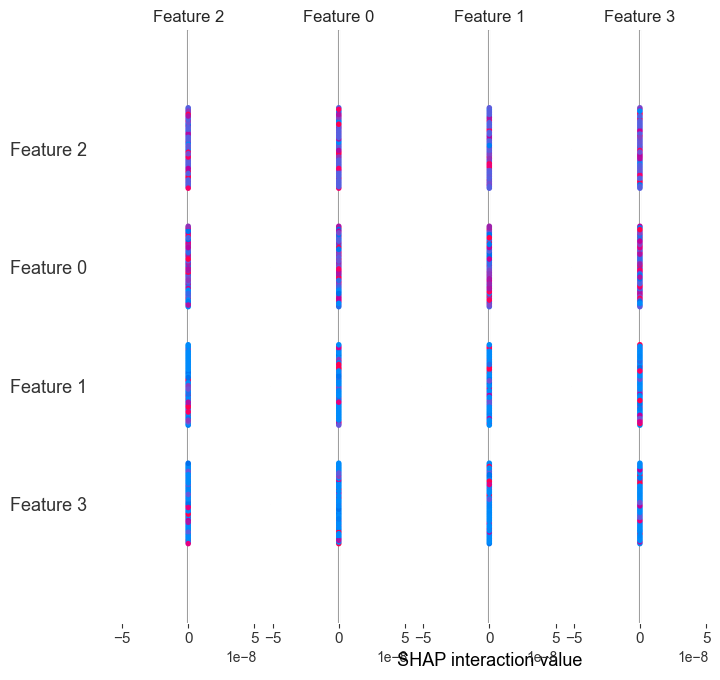

In [13]:
# shap beeswarm plot
import matplotlib.pyplot as plt
import seaborn as sns

# Bright visual theme
plt.style.use("seaborn-v0_8-bright")

plt.figure(figsize=(10,6))

# White background for readability
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Beeswarm (dot) plot with bright colors
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False, color=plt.cm.tab10)

plt.savefig("../results/shap_beeswarm_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [19]:
df.head()

,filepath,emotion,gender_x,emotion_label,predicted,gender_y
0,../data/RADVESS/Actor_02/03-01-05-01-02-01-02.wav,angry,female,0,sad,female
1,../data/RADVESS/Actor_20/03-01-05-01-01-01-20.wav,angry,female,0,sad,female
2,../data/RADVESS/Actor_09/03-01-04-01-02-02-09.wav,sad,male,3,sad,male
3,../data/RADVESS/Actor_15/03-01-03-02-01-01-15.wav,happy,male,1,sad,male
4,../data/RADVESS/Actor_05/03-01-05-02-02-01-05.wav,angry,male,0,sad,male


In [23]:
# recompute shap for male and female
# Filter only rows with gender info
gender_df = df.dropna(subset=["gender"])

# Take small balanced samples
male_df = gender_df[gender_df["gender"]=="male"].sample(20, random_state=42)
female_df = gender_df[gender_df["gender"]=="female"].sample(20, random_state=42)

# Extract MFCC and flatten
X_male_raw = np.array([extract_mfcc(p) for p in male_df["filepath"]])
X_female_raw = np.array([extract_mfcc(p) for p in female_df["filepath"]])

X_male = X_male_raw.reshape(X_male_raw.shape[0], -1)
X_female = X_female_raw.reshape(X_female_raw.shape[0], -1)

print("Male:", X_male.shape, "Female:", X_female.shape)


Male: (20, 8000) Female: (20, 8000)


In [24]:
# recompute shp values for genders
male_shap = explainer.shap_values(X_male, nsamples=50)
female_shap = explainer.shap_values(X_female, nsamples=50)

print("male_shap computed:", type(male_shap))
print("female_shap computed:", type(female_shap))


 40%|████      | 8/20 [00:17<00:20,  1.69s/it]/Users/pc/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
 35%|███▌      | 7/20 [00:18<00:27,  2.12s/it]/Users/pc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.275e-07, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
100%|██████████| 20/20 [00:40<00:00,  2.01s/it]

male_shap computed: <class 'numpy.ndarray'>
female_shap computed: <class 'numpy.ndarray'>


<Figure size 1000x600 with 0 Axes>

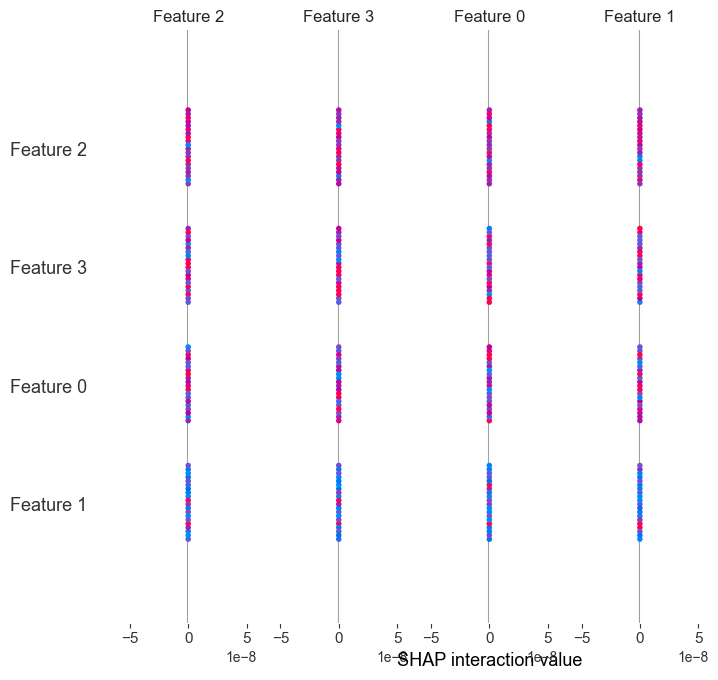

<Figure size 1000x600 with 0 Axes>

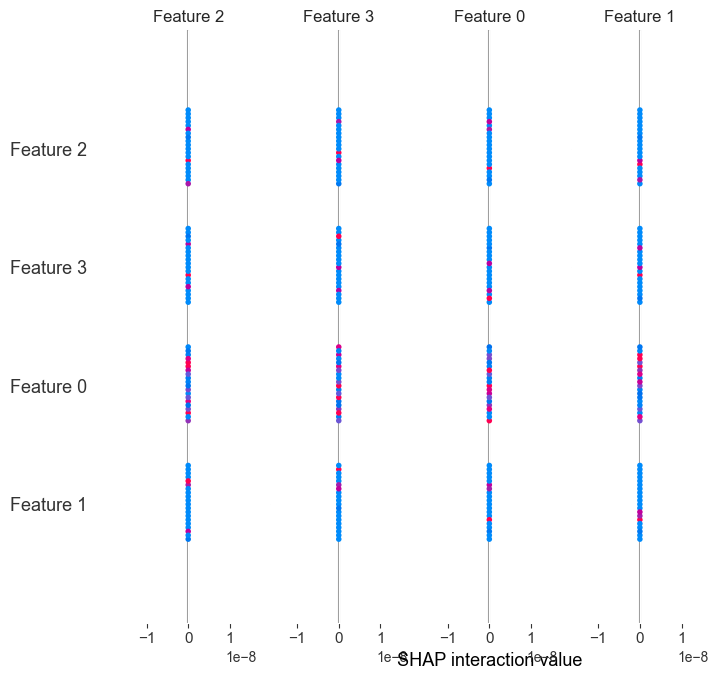

In [25]:
# gender shap values
# Bright theme
plt.style.use("seaborn-v0_8-bright")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Male
plt.figure(figsize=(10,6))
shap.summary_plot(male_shap, X_male, show=False, color=plt.cm.tab10)
plt.savefig("../results/shap_gender_male_summary.png", dpi=300, bbox_inches="tight")
plt.show()

# Female
plt.figure(figsize=(10,6))
shap.summary_plot(female_shap, X_female, show=False, color=plt.cm.tab10)
plt.savefig("../results/shap_gender_female_summary.png", dpi=300, bbox_inches="tight")
plt.show()


In [26]:
gender_shap_stats = pd.DataFrame({
    "group": ["male", "female"],
    "mean_abs_shap": [
        np.mean(np.abs(male_shap)),
        np.mean(np.abs(female_shap))
    ]
})

gender_shap_stats.to_csv("../results/shap_gender_stats.csv", index=False)
gender_shap_stats


,group,mean_abs_shap
0,male,1.860859e-12
1,female,9.685374e-13
